Before finalizing RNA-seq criteria, I need to make sure that all required fields are there and that they are correct.

In [146]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-08-09 
Git hash: 89854bd82cfe77e4a14beea9ea78773bf6a8e113


In [147]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [148]:
# Other imports


In [149]:
# Grab NCBI annotation and make data frame. Will be useful for coloring.
anno = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': '$sra.experiment'},
    {
        '$match': {
            'runs.srr': {"$exists": 1}
        }
    },
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'flag_annotated_rnaseq': {
                '$cond': [
                    {
                        # A run is annotated as rnaseq if one of these is true
                        '$and': [
                            {'$eq': ['RNA-Seq', '$sra.experiment.library_strategy']},
                            {'$eq': ['PolyA', '$sra.experiment.library_selection']},
                        ]
                    }, 
                    True, 
                    False
                ], 
            }
        }
    }
])))
anno.set_index(['srx', 'srr'], inplace=True)

In [150]:
# List of pre-aln-flags
[x['_id'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'flags': '$runs.pre_aln_flags'
        }
    },
    {'$unwind': '$flags'},
    {'$group': {'_id': '$flags'}}
])]

['quality_scores_bad',
 'download_bad',
 'SE',
 'keep_R2',
 'first_strand',
 'complete',
 'unstranded',
 'second_strand',
 'PE',
 'same_strand',
 'opposite_strand',
 'alignment_bad',
 'keep_R1',
 'abi_solid']

In [151]:
# Output samples that have featurecounts. Require at lease 60% alignment
df = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.hisat2.per_alignment': {'$gt': 60},
            'runs.pre_aln_workflow.featurecounts.Assigned': {'$exists': 1},
            'runs.pre_aln_workflow.featurecounts.Assigned_Junction': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'jcount': '$runs.pre_aln_workflow.featurecounts.Assigned_Junction',
            'assigned': '$runs.pre_aln_workflow.featurecounts.Assigned',
        }
    }
])))
df.set_index(['srx', 'srr'], inplace=True)

In [152]:
print(df.shape)
df.head()

(16229, 2)


,,assigned,jcount
srx,srr,,
SRX2541782,SRR5234256,21131907,1590150
SRX2541781,SRR5234255,32744849,2297273
SRX2541780,SRR5234254,29308155,2208976
SRX2541779,SRR5234253,28013703,2117793
SRX2541778,SRR5234252,25203517,1960569


In [153]:
# Calculate the proportion of 
prop_junc = df['jcount'] / df['assigned']

In [154]:
mask = prop_junc.index.isin(anno[anno.flag_annotated_rnaseq].index)

In [159]:
sum(mask)

115

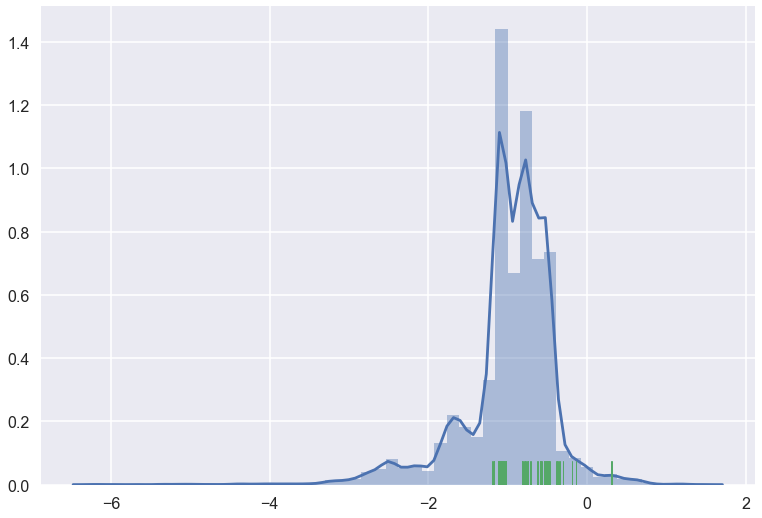

In [161]:
sns.distplot(np.log10(prop_junc))
sns.distplot(np.log10(prop_junc[mask]), hist=False, kde=False, rug=True)